# 代码模块及细节

## 1 初始化

In [4]:
import argparse
import os
import numpy as np
import torch

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches") 
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space") # 随机噪声z的维度
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension") # 输入图像的尺寸
parser.add_argument("--channels", type=int, default=1, help="number of image channels") # 输入图像的channel数
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples") # 保存生成图像和模型的间隔
opt = parser.parse_known_args()[0]
print("opt =", opt)

opt = Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_epochs=200, sample_interval=400)


In [6]:
img_shape = (opt.channels, opt.img_size, opt.img_size)
print("img_shape =", img_shape)

img_shape = (1, 28, 28)


## 2 数据加载

数据格式为 28 * 28 的灰度图，以及对应 0-9 的数字标签

In [7]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),

    batch_size=opt.batch_size,
    shuffle=True,
)

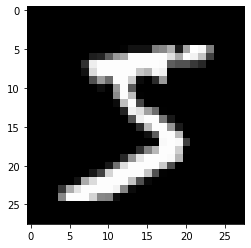

label = 5 



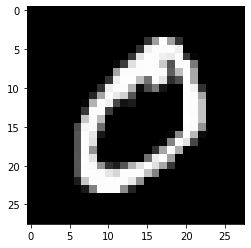

label = 0 



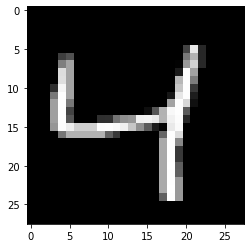

label = 4 



In [8]:
from torch.autograd import Variable
import matplotlib.pyplot as plt

def show_img(img, trans=True):
    if trans:
        img = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))  # 把channel维度放到最后
        plt.imshow(img[:, :, 0], cmap="gray")
    else:
        plt.imshow(img, cmap="gray")
    plt.show()
    
mnist = datasets.MNIST("../../data/mnist")

for i in range(3):
    sample = mnist[i][0]
    label = mnist[i][1]
    show_img(np.array(sample), trans=False)
    print("label =", label, '\n')

In [9]:
trans_resize = transforms.Resize(opt.img_size)
trans_to_tensor = transforms.ToTensor()
trans_normalize = transforms.Normalize([0.5], [0.5]) # x_n = (x - 0.5) / 0.5

print("shape =", np.array(sample).shape, '\n')
print("data =", np.array(sample), '\n')
samlpe = trans_resize(sample)
print("(trans_resize) shape =", np.array(sample).shape, '\n')
sample = trans_to_tensor(sample)
print("(trans_to_tensor) data =", sample, '\n')
sample = trans_normalize(sample)
print("(trans_normalize) data =", sample, '\n')

shape = (28, 28) 

data = [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  67 232  39   0   0   0   0   0]
 [  0   0   0   0  62  81   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 120 180  39   0   0   0   0   0]
 [  0   0   0   0 126 163   0   0   0   0   0   0   0   0   0   0   0   0
    0   2 153 210  40   0   0   0   0   0]
 [  0   0   0   0 220 163   0   0   0 

## 3 模型
### 3.1生成器
包含5个全连接层，使用LeakyReLU和Tanh激活函数，使用了BatchNorm       
![title](figures/Leaky_ReLU.jpg)
![title](figures/tanh.png)

In [10]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img
    
generator = Generator()
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)


### 3.2判别器
包含3个全连接层，使用LeakyReLU和Sigmoid激活函数

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity
    
discriminator = Discriminator()
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## 4 损失函数
使用 Binary Cross Entropy Loss 

In [14]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

## 5 Cuda加速

In [15]:
cuda = True if torch.cuda.is_available() else False
print("cuda_is_available =", cuda)
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

cuda_is_available = True


## 6 优化器
使用Adam优化器

In [16]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
print("learning_rate =", opt.lr)

learning_rate = 0.0002


## 7 创建输入
分别从数据集和随机向量中获取输入

i = 0 

shape of z = torch.Size([64, 100]) 

shape of real_imgs = torch.Size([64, 1, 28, 28]) 

z = tensor([[-2.9495e+00,  1.2388e+00, -4.9072e-01,  ..., -5.2789e-01,
         -1.6913e+00,  4.1134e-01],
        [ 5.8297e-01, -6.9647e-01, -1.0680e+00,  ..., -7.8995e-01,
          1.2220e+00,  6.3353e-01],
        [ 9.9142e-02, -5.8817e-01,  1.1662e+00,  ..., -5.6796e-01,
          2.5947e-01, -1.5556e+00],
        ...,
        [-7.0522e-01, -1.6627e-01, -7.1501e-01,  ...,  1.7543e-02,
          2.0630e+00, -1.1209e+00],
        [ 4.4163e-02, -5.7406e-01, -1.9943e+00,  ..., -1.6272e+00,
         -1.2087e+00, -1.3316e-03],
        [-1.0818e+00,  1.6218e+00,  1.0752e+00,  ...,  7.0025e-01,
          9.7229e-01, -1.1451e+00]], device='cuda:0') 

real_imgs =


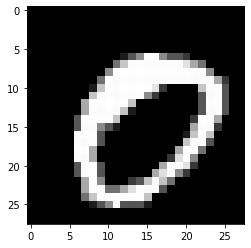

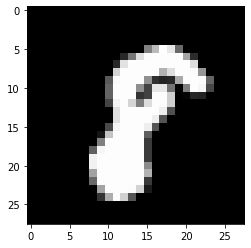

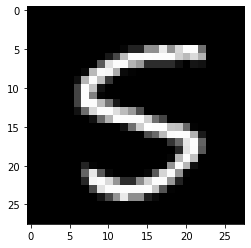

In [18]:
for i, (imgs, _) in list(enumerate(dataloader))[:1]:
    real_imgs = Variable(imgs.type(Tensor))
    # Sample noise as generator input
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
    print("i =", i, '\n')
    print("shape of z =", z.shape, '\n')
    print("shape of real_imgs =", real_imgs.shape, '\n')
    print("z =", z, '\n')
    print("real_imgs =")
    for img in real_imgs[:3]:
        show_img(img)

## 8 计算loss，反向传播
分别对生成器和判别器计算loss，使用反向传播更新模型参数

gen_imgs =


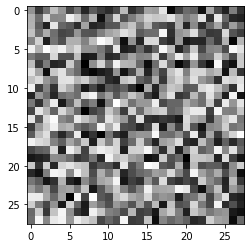

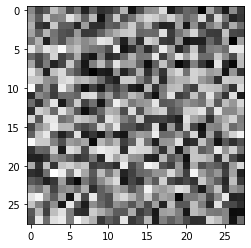

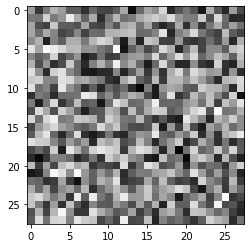

g_loss = tensor(0.7185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) 

real_loss = tensor(0.7050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) 

fake_loss = tensor(0.6684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) 

d_loss = tensor(0.6867, device='cuda:0', grad_fn=<DivBackward0>) 



In [19]:
    # Adversarial ground truths
    valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # 为1时判定为真
    fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # 为0时判定为假
    
    # ---------------------
    #  Train Generator
    # ---------------------
    
    optimizer_G.zero_grad()
    
    gen_imgs = generator(z) # 生成图像
    print("gen_imgs =")
    for img in gen_imgs[:3]:
        show_img(img)

    # Loss measures generator's ability to fool the discriminator
    g_loss = adversarial_loss(discriminator(gen_imgs), valid)
    print("g_loss =", g_loss, '\n')

    g_loss.backward()
    optimizer_G.step()

    # ---------------------
    #  Train Discriminator
    # ---------------------

    optimizer_D.zero_grad()

    # Measure discriminator's ability to classify real from generated samples
    real_loss = adversarial_loss(discriminator(real_imgs), valid)
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2
    print("real_loss =", real_loss, '\n')
    print("fake_loss =", fake_loss, '\n')
    print("d_loss =", d_loss, '\n')    
    
    d_loss.backward()
    optimizer_D.step()

## 9 保存生成图像和模型文件

In [21]:
    from torchvision.utils import save_image

    epoch = 0 # temporary
    batches_done = epoch * len(dataloader) + i
    if batches_done % opt.sample_interval == 0:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True) # 保存生成图像
        
        os.makedirs("model", exist_ok=True) # 保存模型
        torch.save(generator, 'model/generator.pkl') 
        torch.save(discriminator, 'model/discriminator.pkl')
        
        print("gen images saved!\n")
        print("model saved!")

gen images saved!

model saved!
